## Simple Deep Learning With PyTorch
## MNIST Dataset (Predict Number in Image)

In [3]:
# Import Liblaries Needed
import torch
from torch import nn
import numpy as np
from torchvision import datasets, transforms

In [136]:
# Load The Data

transform_train = transforms.Compose([transforms.RandomRotation(30),
                                     transforms.ToTensor(),
                                     transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

transform_test = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])

trainset = datasets.MNIST(root='data', train=True, download=True, transform=transform_train)

testset = datasets.MNIST(root='data', train=False, download=True, transform=transform_test)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=32)

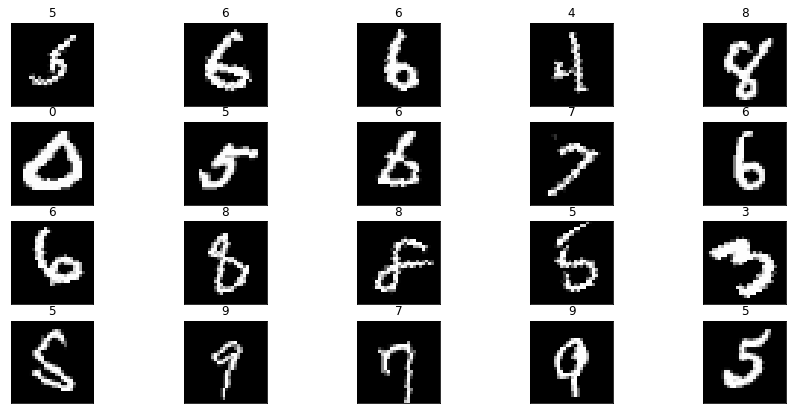

In [137]:
# Visualize The Data
import matplotlib.pyplot as plt

trainiter = iter(trainloader)
testiter = iter(testloader)

images, labels = next(trainiter)

fig = plt.figure(figsize=(15, 7))

for i in np.arange(20):
    ax = fig.add_subplot(4, 20/4, i+1, xticks=[], yticks=[])
    ax.imshow(images[i].squeeze(), cmap='Greys_r')
    ax.set_title(labels[i].item())

In [144]:
# Build Model Architecture
import torch.nn.functional as F

class Network(nn.Module) :
    def __init__(self) :
        super(Network, self).__init__()
        
        self.layer1 = nn.Linear(28*28, 512)
        self.layer2 = nn.Linear(512, 124)
        self.layer3 = nn.Linear(124, 10)
            
        self.relu = nn.ReLU()
        self.logsoftmax = nn.LogSoftmax(dim=1)
        self.dropout = nn.Dropout(p=0.3)
    def forward(self, x) :
        x = x.view(images.shape[0], -1)
        
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        x = self.logsoftmax(self.layer3(x))
            
        return x

In [145]:
# Inspect The Model
model = Network()
model

Network(
  (layer1): Linear(in_features=784, out_features=512, bias=True)
  (layer2): Linear(in_features=512, out_features=124, bias=True)
  (layer3): Linear(in_features=124, out_features=10, bias=True)
  (relu): ReLU()
  (logsoftmax): LogSoftmax()
  (dropout): Dropout(p=0.3)
)

In [146]:
# use cpu or gpu if available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [147]:
## Specify Loss Function and Optimization Function
from torch import optim

criterion = nn.NLLLoss()

optimizer = optim.Adam(model.parameters(), lr=0.003)

epochs = 3

# Training Process and Evaluate Training Loss
for epoch in range(epochs) :
    train_loss = 0
    for images, labels in trainloader :
        
        images, labels = images.to(device), labels.to(device)
        
        steps += 1
        
        optimizer.zero_grad()
        
        output = model.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
    print('Epoch : {}'.format(epoch+1))
    print('Train Loss : {}'.format(train_loss/len(trainloader)))
    

Epoch : 1
Train Loss : 0.6468983139914236
Epoch : 2
Train Loss : 0.4639234871530075
Epoch : 3
Train Loss : 0.41434481632766695


In [161]:
# Evaluate Accuracy

accuracy = 0
for images, labels in trainloader :
    
    images, labels = images.to(device), labels.to(device)
    model.eval()
    output = model.forward(images)
    
    top_p, top_class = output.topk(1, dim=1)
    
    equals = top_class == labels.view(*top_class.shape)
    
    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

model.train()
print('Accuracy : {}%'.format(100*accuracy/len(trainloader)))

Accuracy : 92.24080490405117%


In [163]:
# Evaluate in Unseen Data (Test Data)

test_accuracy = 0
test_loss = 0
for images, labels in testloader :
    
    images, labels = images.to(device), labels.to(device)
    model.eval()
    output = model.forward(images)
    
    loss = criterion(output, labels)
    
    test_loss += loss
    
    top_p, top_class = output.topk(1, dim=1)
    
    equals = top_class == labels.view(*top_class.shape)
    
    test_accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

model.train()
print('Accuracy : {}%'.format(100*test_accuracy/len(testloader)))
print('Test Loss : {}'.format(test_loss/len(testloader)))

Accuracy : 94.3091054313099%
Test Loss : 0.18334588408470154


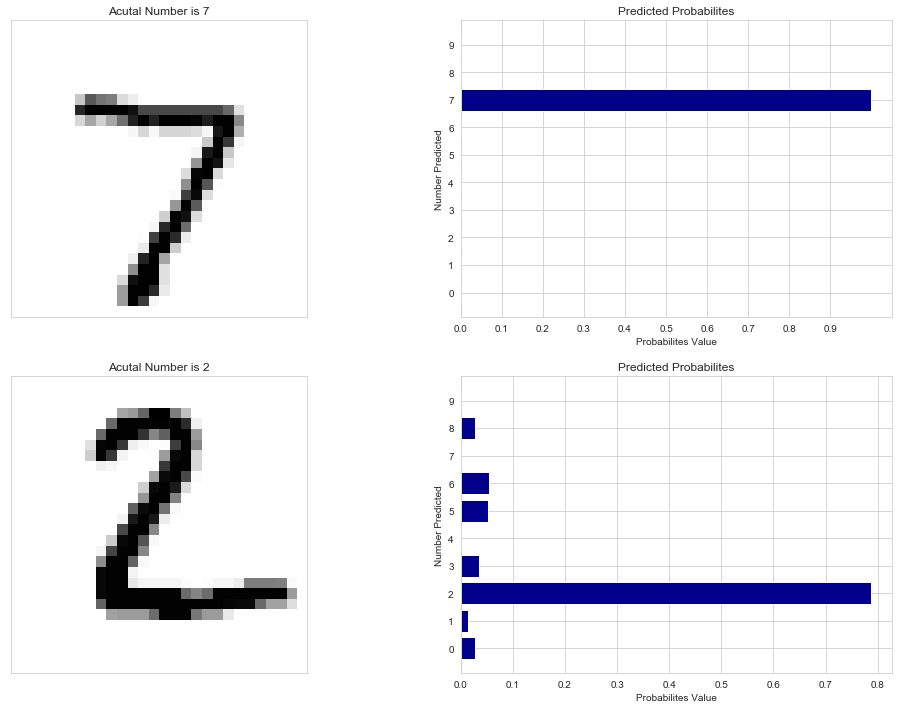

In [191]:
# Visualize Predict Result
import seaborn as sns

sns.set_style("whitegrid")

images, labels = next(iter(testloader))

images, labels = images.to(device), labels.to(device)

output = model.forward(images)

fig = plt.figure(figsize=(17, 12))
for i in range(2) :
    ax1 = fig.add_subplot(2, 2, 2*i+1, xticks=[], yticks=[])
    ax2 = fig.add_subplot(2, 2, 2*i+2, xticks=np.arange(0, 1, 0.1), yticks=np.arange(0, 10))
    
    ax1.imshow(images[i].squeeze(), cmap='Greys')
    ax1.set_title("Acutal Number is {}".format(labels[i].item()))
    
    ax2.barh(np.arange(0, 10), torch.exp(output[i].detach()), color='DarkBlue')
    ax2.set_xlabel('Probabilites Value')
    ax2.set_ylabel('Number Predicted')
    ax2.set_title('Predicted Probabilites')